In [9]:
from sklearn import svm, metrics
import glob, os.path, re, json
# 텍스트를 읽어 들이고 출현 빈도 조사하기 --- (※1)
def check_freq(fname):
    name = os.path.basename(fname)  # 파일명 가져오기
    lang = re.match(r'^[a-z]{2,}', name).group() # a부터 z까지가 2번 이상 반복 # 나라id 분류 group()
    #  group()은 정규 표현식에 일치하는 것만 가져옴. 파일명에서 a부터 z까지가 2번 이상 나오는 문자를 가져온다.
    with open(fname, "r", encoding="utf-8") as f:
        text = f.read()
    text = text.lower() # 소문자 변환:파일에 있는 모든 내용을 소문자로 읽어 옴.

    #숫자 세기 변수(cnt) 초기화하기
    cnt = [0 for n in range(0, 26)] # 0으로 이루어진 26요소를 가진 리스트 cnt
    code_a = ord("a") # a에 해당하는 아스키값 가지고 오기
    code_z = ord("z") # z에 해당하는 아스키값 가지고 오기

    # 알파벳 출현 횟수 구하기 --- (※2)
    for ch in text:
        n = ord(ch)
        if code_a <= n <= code_z: # a~z 사이에 있을 때
            cnt[n - code_a] += 1 # a가 몇번 나왔는지 b가 몇번 나왔는지 z가지 카운트를 한다.
    # 정규화하기 --- (※3)
    total = sum(cnt)  #리스트에 있는 값 모두 더하기
    freq = list(map(lambda n: n / total, cnt))
    return (freq, lang)
    
# 각 파일 처리하기
def load_files(path):
    freqs = []
    labels = []
    file_list = glob.glob(path)
    for fname in file_list:
        r = check_freq(fname)
        freqs.append(r[0])
        labels.append(r[1])
    return {"freqs":freqs, "labels":labels}
data = load_files("./lang/train/*.txt")
test = load_files("./lang/test/*.txt")
# 이후를 대비해서 JSON으로 결과 저장하기
with open("./lang/freq.json", "w", encoding="utf-8") as fp:
    json.dump([data, test], fp)
# 학습하기 --- (※4)
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])
# 예측하기 --- (※5)
predict = clf.predict(test["freqs"])
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(test["labels"], predict)
cl_report = metrics.classification_report(test["labels"], predict)
print("정답률 =", ac_score)
print("리포트 =")
print(cl_report)

ok, {'thin': 6392, 'normal': 5886, 'fat': 7722}


In [ ]:
# c:\> pip install matplotlib numpy pandas

import matplotlib.pyplot as plt
import pandas as pd
import json
# 알파벳 출현 빈도 데이터 읽어 들이기 --- (※1)
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    freq = json.load(fp)
# 언어마다 계산하기 --- (※2)
#print(freq)
lang_dic = {}
for i, lbl in enumerate(freq[0]["labels"]):
    fq = freq[0]["freqs"][i]
    if not (lbl in lang_dic):
        lang_dic[lbl] = fq
        continue
    for idx, v in enumerate(fq):
        lang_dic[lbl][idx] = (lang_dic[lbl][idx] + v) / 2 # 그래프를 그릴 수 있게 언어의 빈도를 집계

# Pandas의 DataFrame에 데이터 넣기 --- (※3)
asclist = [[chr(n) for n in range(97,97+26)]]
df = pd.DataFrame(lang_dic, index=asclist) # index를 a~z까지로 사용
# 그래프 그리기 --- (※4)
plt.style.use('ggplot')
df.plot(kind="bar", subplots=True, ylim=(0,0.15))
plt.savefig("lang-plot.png")


In [ ]:
# 웹 인터페이스 추가하기

from sklearn import svm 
import sklearn.externals 
import joblib
import json
# 각 언어의 출현 빈도 데이터(JSON) 읽어 들이기
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    d = json.load(fp)
    data = d[0]
# 데이터 학습하기
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])
# 학습 데이터 저장하기
joblib.dump(clf, "./lang/freq.pkl")
print("ok")

In [ ]:
#!/usr/bin/env python3
# lang-Webapp.py

# python –m http.server --cgi 8080
# http://127.0.0.1:8080/으로 경로 확인
# 경로에 lang-Webapp.py 저장 
# http://localhost:8080/cgi-bin/lang-Webapp.py

import cgi, os.path
import sklearn.externals 
import joblib
# 학습 데이터 읽어 들이기
pklfile = os.path.dirname(__file__) + "./freq.pkl"
clf = joblib.load(pklfile)
# 텍스트 입력 양식 출력하기
def show_form(text, msg=""):
    print("Content-Type: text/html; charset=utf-8")
    print("")
    print("""
        <html><body><form>
        <textarea name="text" rows="8" cols="40">{0}</textarea>
        <p><input type="submit" value="판정"></p>
        <p>{1}</p>
        </form></body></html>
    """.format(cgi.escape(text), msg))
# 판정하기
def detect_lang(text):
    # 알파벳 출현 빈도 구하기
    text = text.lower() 
    code_a, code_z = (ord("a"), ord("z"))
    cnt = [0 for i in range(26)]
    for ch in text:
        n = ord(ch) - code_a
        if 0 <= n < 26: cnt[n] += 1
    total = sum(cnt)
    if total == 0: return "입력이 없습니다"
    freq = list(map(lambda n: n/total, cnt))
    # 언어 예측하기
    res = clf.predict([freq])
    # 언어 코드를 한국어로 변환하기
    lang_dic = {"en":"영어","fr":"프랑스어",
        "id":"인도네시아어", "tl":"타갈로그어"}
    return lang_dic[res[0]]
# 입력 양식의 값 읽어 들이기
form = cgi.FieldStorage()
text = form.getvalue("text", default="")
msg = ""
if text != "":
    lang = detect_lang(text)
    msg = "판정 결과:" + lang
# 입력 양식 출력
show_form(text, msg)

In [ ]:
import random
# BMI를 계산해서 레이블을 리턴하는 함수
def calc_bmi(h, w):
    bmi = w / (h/100) ** 2      #  <BMI> = <몸무게(kg)> / (<키(m)> * <키(m)>)    
    if bmi < 18.5: return "thin"
    if bmi < 25: return "normal"
    return "fat"
# 출력 파일 준비하기
fp = open("bmi.csv","w",encoding="utf-8")
fp.write("height,weight,label\r\n")
# 무작위로 데이터 생성하기
cnt = {"thin":0, "normal":0, "fat":0}
for i in range(20000):
    h = random.randint(120,200)
    w = random.randint(35, 80)
    label = calc_bmi(h, w)
    cnt[label] += 1
    fp.write("{0},{1},{2}\r\n".format(h, w, label))   # BMI계산에 따른 데이터 저장
fp.close()
print("ok,", cnt)

In [26]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
# 키와 몸무게 데이터 읽어 들이기 --- (※1)
tbl = pd.read_csv("bmi.csv")
# 칼럼(열)을 자르고 정규화하기 --- (※2)
label = tbl["label"]
w = tbl["weight"] / 100 # 최대 100kg라고 가정
h = tbl["height"] / 200 # 최대 200cm라고 가정
wh = pd.concat([w, h], axis=1) # pandas 를 이용해서  for문 없이 데이터 저장
#wh = tbl[["weight","height"]]
print(wh)
# 학습 전용 데이터와 테스트 전용 데이터로 나누기 --- (※3)
data_train, data_test, label_train, label_test = train_test_split(wh, label)
# 데이터 학습하기 --- (※4)
clf = svm.SVC()
clf.fit(data_train, label_train)
# 데이터 예측하기 --- (※5)
predict = clf.predict(data_test)
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)
print("정답률 =", ac_score)
print("리포트 =\n", cl_report)

       weight  height
0        0.73   0.790
1        0.40   0.920
2        0.51   0.900
3        0.55   0.935
4        0.64   0.925
...       ...     ...
19995    0.78   0.770
19996    0.59   0.835
19997    0.67   0.800
19998    0.61   0.995
19999    0.76   0.830

[20000 rows x 2 columns]
정답률 = 0.9966
리포트 =
               precision    recall  f1-score   support

         fat       1.00      1.00      1.00      1887
      normal       0.99      1.00      0.99      1485
        thin       1.00      0.99      1.00      1628

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



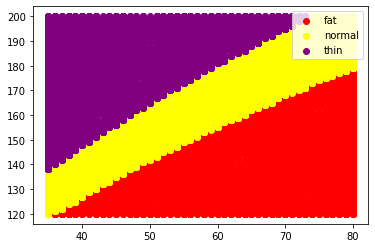

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
# Pandas로 CSV 파일 읽어 들이기
tbl = pd.read_csv("bmi.csv", index_col=2)
# 그래프 그리기 시작
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# 서브 플롯 전용 - 지정한 레이블을 임의의 색으로 칠하기
def scatter(lbl, color):
    b = tbl.loc[lbl]
    ax.scatter(b["weight"],b["height"], c=color, label=lbl)
scatter("fat",    "red")
scatter("normal", "yellow")
scatter("thin",   "purple")
ax.legend() 
plt.savefig("bmi-test.png")
# plt.show()

In [27]:
# 랜덤 포레스트
# 버섯 데이터 셋을 내려 받고 데이터 형식을 확인해 보자.
import urllib.request as req
local= "mushroom.csv"
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
req.urlretrieve(url, local)
print("ok")

ok


In [28]:
# 머신러닝을 할 때는 이를 어떻게 숫자로 변환하는지가 문제이다. 
# 일단 각각의 기호가 한 글자라는 것에 주목해서 각 기호를 문자 코드로 변환해서 활용하자.

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
# 데이터 읽어 들이기--- (※1)
mr = pd.read_csv("mushroom.csv", header=None)
# 데이터 내부의 기호를 숫자로 변환하기--- (※2)
label = []
data = []
attr_list = []
for row_index, row in mr.iterrows():
    label.append(row.iloc[0])
    row_data = []
    for v in row.iloc[1:]:
        row_data.append(ord(v))
    data.append(row_data)
# 학습 전용과 테스트 전용 데이터로 나누기 --- (※3)
data_train, data_test, label_train, label_test = train_test_split(data, label)
# 데이터 학습시키기 --- (※4)
clf = RandomForestClassifier()
clf.fit(data_train, label_train)
# 데이터 예측하기 --- (※5)
predict = clf.predict(data_test)
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)
print("정답률 =", ac_score)
print("리포트 =\n", cl_report)

정답률 = 1.0
리포트 =
               precision    recall  f1-score   support

           e       1.00      1.00      1.00      1088
           p       1.00      1.00      1.00       943

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [1]:
## 랜덤 포레스트
# 머신러닝에서 자주 사용되는 알고리즘으로 "랜덤 포레스트(숲)"라는 것이 있다. (인기투표)
# 이는 학습 전용 데이터를 샘플링해서 여러 개의 의사결정 트리를 만들고, 
# # 만들어진 의사결정 트리를 기반으로 다수결로 결과를 결정하는 방법이다.
# 다수결로 결과를 유도하므로 높은 정밀도를 자랑한다. 
# 학습 데이터를 무작위로 샘플링해서 만들어진 다수의 ”의사결정 트리“라는 것은 트리 구조를 하고 있는 그래프인데 
# 예측과 분류를 수행하는 알고리즘 자체를 의사결정 트리라고 부르기도 한다.

import urllib.request as req
local= "mushroom.csv"   # 독이 있으면 ”p(poisonous)“, 식용이면 ”e(edible)“이다. 첫번째 열
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
req.urlretrieve(url, local)
print("ok")

ok


In [11]:
# 두 번째 열은 버섯의 머리모양이다.
# 네 번째 열은 버섯 머리 색이다. 
# 머신러닝을 할 때는 이를 숫자로 변환
# 각의 기호가 한 글자라는 것에 주목해서 각 기호를 문자 코드로 변환해서 활용하자.
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
# 데이터 읽어 들이기--- (※1)
mr = pd.read_csv("mushroom.csv", header=None)
# 데이터 내부의 기호를 숫자로 변환하기--- (※2)
label = []
data = []
attr_list = []
for row_index, row in mr.iterrows(): # dataframe에 있는 값을 한행씩 가져오기 위해 사용된 iterrows()함수 
    label.append(row.iloc[0]) # 첫번째 열값을 가져온다.  독의 유무
    row_data = [] 
    for v in row.iloc[1:]: 
        row_data.append(ord(v)) # 두번째 열 부터 문자에 해당하는 숫자로 변환하여 저장
    data.append(row_data)

# 학습 전용과 테스트 전용 데이터로 나누기 --- (※3)
data_train, data_test, label_train, label_test = train_test_split(data, label)
# 데이터 학습시키기 --- (※4)
clf = RandomForestClassifier() #  램덤 포레스트객체 생성
clf.fit(data_train, label_train)
# 데이터 예측하기 --- (※5)
predict = clf.predict(data_test)
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)
print("정답률 =", ac_score)
print("리포트 =\n", cl_report)

정답률 = 1.0
리포트 =
               precision    recall  f1-score   support

           e       1.00      1.00      1.00      1043
           p       1.00      1.00      1.00       988

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
# 데이터 읽어 들이기
mr = pd.read_csv("mushroom.csv", header=None)
# 데이터 내부의 분류 변수 전개하기
label = []
data = []
attr_list = []
#print(mr)
# print(mr.iloc[0])
# print(mr.iloc[0][0])
# print(mr.iloc[0][1:])
for row_index, row in mr.iterrows():
    label.append(row.iloc[0]) # 첫 번째 열에 있는 독이 있는 없는 지 
    exdata = [] 
    for col, v in enumerate(row.iloc[1:]):
        if row_index == 0:   
            attr = {"dic": {}, "cnt":0}
            attr_list.append(attr)
            #print(attr_list)
        else:
            attr = attr_list[col]
        
        
        # 버섯의 특징 기호를 배열로 나타내기
        d = [0,0,0,0,0,0,0,0,0,0,0,0]
        if v in attr["dic"]:
            idx = attr["dic"][v]
        else:
            idx = attr["cnt"]
            attr["dic"][v] = idx
            attr["cnt"] += 1
        d[idx] = 1
        exdata += d
    data.append(exdata)
#print(data[0:5])
# 학습 전용 데이터와 테스트 전용 데이터로 나누기
data_train, data_test, label_train, label_test = train_test_split(data, label)
# 데이터 학습시키기
clf = RandomForestClassifier()
clf.fit(data_train, label_train)
# 데이터 예측하기
predict = clf.predict(data_test)
# 결과 테스트하기
ac_score = metrics.accuracy_score(label_test, predict)
print("정답률 =", ac_score)

정답률 = 1.0


In [86]:
# 데이터를 검증하는 방법
# 크로스 밸리데이션 (교차 검증)
# K분할 교차 검증(K-fold cross validation)
# ① 집합 x를 A,B,C로 분할한다. 
# ② A를 덱스트 전용 데이터, 나머지 B/C를 훈련 전용 데이터로 사용해 분류 정밀도 s1을 구한다.
# ③ B를 덱스트 전용 데이터, 나머지 A/C를 훈련 전용 데이터로 사용해 분류 정밀도 s2을 구한다.
# ④ C를 덱스트 전용 데이터, 나머지 A/B를 훈련 전용 데이터로 사용해 분류 정밀도 s3을 구한다.
# ⑤ 분류 정밀도 s1,s2,s3의 평균을 구해 최종적인 분류 정밀도를 구한다.

from sklearn import svm, metrics
import random, re
# 붓꽃의 CSV 파일 읽어 들이기 --- (※1)
lines = open('iris.csv', 'r', encoding='utf-8').read().split("\n")
f_tonum = lambda n : float(n) if re.match(r'^[0-9\.]+$', n) else n
f_cols  = lambda li: list(map(f_tonum,li.strip().split(',')))
csv = list(map(f_cols, lines))
#print(csv)
del csv[0] # 헤더 제거하기
random.shuffle(csv) # 데이터 섞기
# 데이터를 K개로 분할하기 --- (※2)
K = 5 
csvk = [ [] for i in range(K) ] # 다섯개의 리스트를 가진 리스트
for i in range(len(csv)):
    csvk[i % K].append(csv[i]) #  i를 k로 나눈 나머지 index에 csv[i]값을 저장
# print(csvk[0]);print(csvk[1]);print(csvk[2]);print(csvk[3]);print(csvk[4]);
# 리스트를 훈련 전용 데이터와 테스트 전용 데이터로 분할하는 함수
def split_data_label(rows):
    data = []; label = []
    for row in rows:
        data.append(row[0:4])
        label.append(row[4])
    return (data, label)
# 정답률 구하기 --- (※3)
def calc_score(test, train):
    print("실행")
    test_f, test_l = split_data_label(test)
    train_f, train_l = split_data_label(train)
    # 학습시키고 정답률 구하기
    clf = svm.SVC()
    clf.fit(train_f, train_l)
    pre = clf.predict(test_f)
    return metrics.accuracy_score(test_l, pre) 
# K개로 분할해서 정답률 구하기 --- (※4)
score_list = []

for testc in csvk:
    #print("A : ", testc)
    # testc 이외의 데이터를 훈련 전용 데이터로 사용하기 : csvk에서 처음 것만 test용 나머지는 훈련용으로 사용
    trainc = []
    for i in csvk:
        if i != testc: 
            #print("B :  ",i)
            trainc += i
    sc = calc_score(testc, trainc)
    score_list.append(sc) # 각 정답률을 리스트에 저장

print("각각의 정답률 =", score_list)
print("평균 정답률 =", sum(score_list) / len(score_list))

실행
실행
실행
실행
실행
각각의 정답률 = [0.9333333333333333, 0.9666666666666667, 1.0, 0.9333333333333333, 0.9333333333333333]
평균 정답률 = 0.9533333333333334


In [87]:
import pandas as pd
from sklearn import svm, metrics, model_selection
import random, re
# 붓꽃의 CSV 데이터 읽어 들이기 --- (※1)
csv = pd.read_csv('iris.csv')
# 리스트를 훈련 전용 데이터와 테스트 전용 데이터로 분할하기 --- (※2)
data = csv[["SepalLength","SepalWidth","PetalLength","PetalWidth"]]
label = csv["Name"]
# 크로스 밸리데이션하기 --- (※3)
clf = svm.SVC()
scores = model_selection.cross_val_score(clf, data, label, cv=5)
print("각각의 정답률 =", scores)
print("평균 정답률 =", scores.mean())

각각의 정답률 = [0.96666667 0.96666667 0.96666667 0.93333333 1.        ]
평균 정답률 = 0.9666666666666666


In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
x_train,x_test,y_train,y_test = train_test_split(iris.data,iris.target,random_state = 0)

print("훈련 세트의 크기 : {} 테스트 세트의 크기 {}".format(x_train.shape[0],x_test.shape[0]))

best_score = 0

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        svm = SVC(gamma = gamma,C = C)
        svm.fit(x_train,y_train)
        score = svm.score(x_test,y_test)

        if score > best_score:
            best_score = score
            best_parameters = {'C' : C,'gamma' : gamma}


print("최고 점수 {:.2f}".format(best_score))
print("최적 매개변수 : ",best_parameters)


훈련 세트의 크기 : 112 테스트 세트의 크기 38
최고 점수 0.97
최적 매개변수 :  {'C': 100, 'gamma': 0.001}


In [7]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 데이터를 로딩하고 학습데이타와 테스트 데이터 분리
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=121)
dtree = DecisionTreeClassifier()

### parameter 들을 dictionary 형태로 설정
parameters = {'max_depth':[1,2,3], 'min_samples_split':[2,3]}


# param_grid의 하이퍼 파라미터들을 3개의 train, test set fold 로 나누어서 테스트 수행 설정.  
### refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재 학습 시킴.  
grid_dtree = GridSearchCV(dtree, param_grid=parameters, cv=3, refit=True)

# 붓꽃 Train 데이터로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가 .
grid_dtree.fit(X_train, y_train)

# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_dtree.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'min_samples_split': 2}",0.700000,5,0.700,0.7,0.70
1,"{'max_depth': 1, 'min_samples_split': 3}",0.700000,5,0.700,0.7,0.70
2,"{'max_depth': 2, 'min_samples_split': 2}",0.958333,3,0.925,1.0,0.95
3,"{'max_depth': 2, 'min_samples_split': 3}",0.958333,3,0.925,1.0,0.95
4,"{'max_depth': 3, 'min_samples_split': 2}",0.975000,1,0.975,1.0,0.95
5,"{'max_depth': 3, 'min_samples_split': 3}",0.975000,1,0.975,1.0,0.95


In [12]:
# 그리드 서치
# 매개변수가 여러개를 지정할 수 있는데 적절하게 매개변수를 지정을 해야 정답률이 높아지게 된다.
# 어떤 매개변수가 적당한지 조사하는 방법을 '그리드 서치'라고 한다.
# 관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도하여 최적의 매개변수를 찾는 방법 
# 매개변수를 튜닝하여 일반화 성능을 개선해줌
import pandas as pd
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
# MNIST 학습 데이터 읽어 들이기 --- (※1)
train_csv = pd.read_csv("./mnist/train.csv")
test_csv  = pd.read_csv("./mnist/t10k.csv")
# 필요한 열 추출하기 --- (※2)
train_label = train_csv.iloc[:, 0]
train_data  = train_csv.iloc[:, 1:577]
test_label  = test_csv.iloc[:, 0]
test_data   = test_csv.iloc[:, 1:577]
print("학습 데이터의 수 =", len(train_label))
# 그리드 서치 매개변수 설정 --- (※3)
### parameter 들을 dictionary 형태로 설정

params = [
    {"C": [1,10,100,1000], "kernel":["linear"]},
    {"C": [1,10,100,1000], "kernel":["rbf"], "gamma":[0.001, 0.0001]}
]

# 그리드 서치 수행 --- (※4)
clf = GridSearchCV( svm.SVC(), params, n_jobs=-1 )
clf.fit(train_data, train_label)
print("학습기 =", clf.best_estimator_)
# 테스트 데이터 확인하기 --- (※5)
pre = clf.predict(test_data)
ac_score = metrics.accuracy_score(pre, test_label)
print("정답률 =",ac_score)

학습 데이터의 수 = 1000
학습기 = SVC(C=1, kernel='linear')


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 0.451
- 0.452
- 0.453
- 0.454
- 0.455
- ...
Feature names seen at fit time, yet now missing:
- 1
- 1.1
- 107
- 108
- 11
- ...

  warnings.warn(message, FutureWarning)


정답률 = 0.866


# 딥러닝 개요.
기존 방식에서는 특징을 하나하나 지정해 주었다면 딥러닝에서는 알아서 특징을 추출한다는 것이다.
딥러닝에서는 대량의 데이터를 학습시키면 특징을 직접 찾아낸다. 
이러한 특징을 찾아 내기 위한 방법으로 신경망을 이용하는 것이라고 할 수 있다.
신경망은 인간의 뇌를 본따 만든 네트워크 구조이다.

입력된 데이터들은 입력층, 중간츨, 출력층을 거쳐 처리가 이루어지고 최종적인 결과가 출력이 된다.
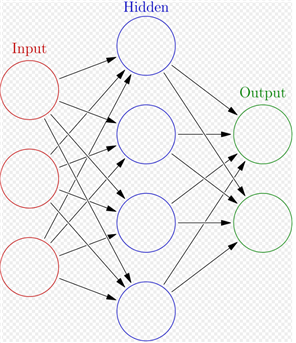
딥러닝은 대량의 데이터를 입력해서 학습을 시키며 학습이란 뉴런의 접속 가충치를 조정하는 것을 의미한다.


# 퍼셉트론
단순 퍼셉트론(Simple Perceptron)
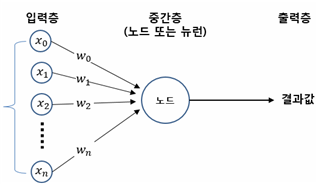

현재 그림에서 퍼셉트론은 x0, x1, x2, ..., xn 라는 출력을 가지고 있다. 각 입력에는 0또는 1을 입력하기로 했으며, 출력에서는 0또는 1이 출력이 나온다.

예로 새로운 스마트폰을 구매해야 할지에 대해 살펴보자.
* 이번달의 수입이 충분한가?(x1)
* 최신 기종을 가지고 있는가?(x2)
* 기존의 스마트폰에 문제가 있는가?(x3)

조건이 대충 절반이상(2개)만족한다는 이유로 스마트폰을 구입해도 될까?

입력 x1, x2, x3에 대한 가중치를 w1, w2, w3라고 했을 때 
부자라면 (w1 = 1, w2 = 8 , w3 = 3)처럼 가중치를 설정할 것이다. 
지금 사용하는 스마트폰에 문제가 생긴 사람이라면 (w1 = 2, w2 = 2, w3 = 8)처럼 가중치를 설정할 것이다 
정기적으로 최신 스카트폰을 구입하는 사람이라면 (w1 = 3, w2 = 6, w3 = 5)처럼 가중치를  설정할 수 있을 것이다.

# TensorFlow
1차원 : 백터
2차원 : 행렬
다차원 행렬 : Tensor(텐서)

#tensorflow(cpu 버전) 설치

pip install  tensorflow

#Keras

pip install keras==2.2.2

pip install –U h5py graphviz pydot 

In [1]:
# TensorFlow 임포트 --- (※1)
import tensorflow as tf

# 상수 정의 --- (※2)
a = tf.constant(1234)
b = tf.constant(5000)


# 계산 정의 --- (※3)
@tf.function
def add_op(a, b):
    return a + b


# 세션 시작하기 --- (※4)
res = add_op(a, b).numpy()        # 식 평가하기 , 플로 그래프(그래프 알고리즘이 기초)를 이용하여 객체를 구축
print(res)

tf.Tensor(6234, shape=(), dtype=int32)


In [2]:
# TensorFlow 읽어 들이기 --- (※1)
import tensorflow as tf

# 상수 정의하기 --- (※2)
a = tf.constant(2)
b = tf.constant(3)
c = tf.constant(4)


# 연산 정의하기 --- (※3)
@tf.function
def calc1_op():
    return a + b * c

@tf.function
def calc2_op():
    return (a + b) * c


# 세션 시작하기 --- (※4)
res1 = calc1_op().numpy() # 식 평가하기
print(res1)
res2 = calc2_op().numpy() # 식 평가하기
print(res2)

14
20


In [3]:
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

# 상수 정의하기 --- (※1)
a = tf.constant(120, name="a")
b = tf.constant(130, name="b")
c = tf.constant(140, name="c")
# 변수 정의하기 --- (※2)
v = tf.Variable(0, name="v")
# 데이터 플로우 그래프 정의하기 --- (※3)
calc_op = a + b + c
assign_op = tf.assign(v, calc_op)
# 세션 실행하기 --- (※4)
sess = tf.Session()
sess.run(assign_op)
# v의 내용 출력하기 --- (※5)
print( sess.run(v) )

390


In [4]:
# TensorFlow의 플레이스홀더
# 템플릿처럼 값을 넣을 공간을 만들어두는 기능
# 세션을 실행할 때 그릇에 값을 넣고 실행
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

# 플레이스홀더 정의하기 --- (※1)
a = tf.placeholder(tf.int32, [3]) # 정수 자료형 3개를 가진 배열
# 배열을 모든 값을 2배하는 연산 정의하기 --- (※2)
b = tf.constant(2)
x2_op = a * b
# 세션 시작하기 --- (※3)
sess = tf.Session()
# 플레이스홀더에 값을 넣고 실행하기 --- (※4)
r1 = sess.run(x2_op, feed_dict={ a:[1, 2, 3] })
print(r1)
r2 = sess.run(x2_op, feed_dict={ a:[10, 20, 10] })
print(r2)

[2 4 6]
[20 40 20]


In [5]:
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

# 플레이스홀더 정의하기 --- (※1)
a = tf.placeholder(tf.int32, [None]) # 배열의 크기를 None으로 지정
# 배열의 모든 값을 10배하는 연산 정의하기 
b = tf.constant(10)
x10_op = a * b
# 세션 시작하기
sess = tf.Session()
# 플레이스홀더에 값을 넣어 실행하기 --- (※2)
r1 = sess.run(x10_op, feed_dict={a: [1,2,3,4,5]})
print(r1)
r2 = sess.run(x10_op, feed_dict={a: [10,20]})
print(r2)

[10 20 30 40 50]
[100 200]


In [3]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

# 키, 몸무게, 레이블이 적힌 CSV 파일 읽어 들이기 --- (※1)
csv = pd.read_csv("bmi.csv")
# 데이터 정규화 --- (※2)
csv["height"] = csv["height"] / 200   # 브로드케스팅
csv["weight"] = csv["weight"] / 100
# 레이블을 배열로 변환하기 --- (※3)
# - thin=(1,0,0) / normal=(0,1,0) / fat=(0,0,1)
bclass = {"thin": [1,0,0], "normal": [0,1,0], "fat": [0,0,1]}
csv["label_pat"] = csv["label"].apply(lambda x : np.array(bclass[x])) 
# csv["label"]에 있는 값이 "thin"이면 [1,0,0], "normal"이면 [0,1,0], "fat"이면 [0,0,1]을 csv에 "label_pat"를 만들어 저장

# 테스트를 위한 데이터 분류 --- (※4)
test_csv = csv[15000:20000]
test_pat = test_csv[["weight","height"]]
test_ans = list(test_csv["label_pat"])
# 데이터 플로우 그래프 구축하기 --- (※5)
# 플레이스홀더 선언하기
x  = tf.placeholder(tf.float32, [None, 2]) # 키와 몸무게 데이터 넣기
y_ = tf.placeholder(tf.float32, [None, 3]) # 정답 레이블 넣기
# 변수 선언하기 --- (※6)
W = tf.Variable(tf.zeros([2, 3])); # 가중치
b = tf.Variable(tf.zeros([3])); # 바이어스
# 소프트맥스 회귀 정의하기 --- (※7)
y = tf.nn.softmax(tf.matmul(x, W) + b)
# 모델 훈련하기 --- (※8)
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(cross_entropy)
# 정답률 구하기
predict = tf.equal(tf.argmax(y, 1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(predict, tf.float32))
# 세션 시작하기
sess = tf.Session()
sess.run(tf.global_variables_initializer()) # 변수 초기화하기
# 학습시키기
for step in range(3500):
    i = (step * 100) % 14000
    rows = csv[1 + i : 1 + i + 100]
    x_pat = rows[["weight","height"]]
    y_ans = list(rows["label_pat"])
    fd = {x: x_pat, y_: y_ans}
    sess.run(train, feed_dict=fd)
    if step % 500 == 0:
        cre = sess.run(cross_entropy, feed_dict=fd)
        acc = sess.run(accuracy, feed_dict={x: test_pat, y_: test_ans})
        print("step=", step, "cre=", cre, "acc=", acc)
# 최종적인 정답률 구하기
acc = sess.run(accuracy, feed_dict={x: test_pat, y_: test_ans})
print("정답률 =", acc)

0           fat
1          thin
2          thin
3          thin
4        normal
          ...  
19995       fat
19996    normal
19997       fat
19998      thin
19999       fat
Name: label, Length: 20000, dtype: object
step= 0 cre= 109.39801 acc= 0.2926
step= 500 cre= 58.282223 acc= 0.868
step= 1000 cre= 46.247185 acc= 0.9282
step= 1500 cre= 38.766785 acc= 0.944
step= 2000 cre= 36.01812 acc= 0.9582
step= 2500 cre= 34.1697 acc= 0.9604
step= 3000 cre= 31.909721 acc= 0.9654
정답률 = 0.9686


# 선형회귀
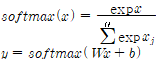
y = ((y2 - y1/x2 - x1)) (x - x1)     =>  y = Wx + b
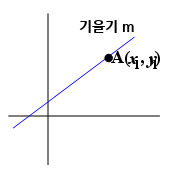 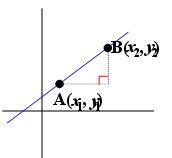
로지스틱 회귀 : 합격, 불합격과 같이 두가지의 경우만 가지고 0~1사이의 값을 가지며 두개의 합을 구하면 1이된다.
                  
                  H(x) = sigmoid(Wx + b)
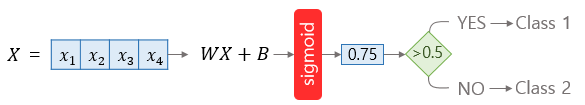
1. W가 1이고 b가 0인 그래프

소프트맥스 회귀 : 세 개 이상의 답 중 하나를 고르는 문제를 다중 클래스 분류(Multi-class Classification)라고 합니다.
                  
                  H(x) = softmax(Wx + b)
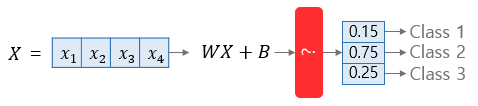

In [13]:
# 5-5.TensorBoard로 시각화하기
# pip install --upgrade --user tensorflow_gpu
# C:\>tensorboard --logdir==logdir
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

# 데이터 플로우 그래프 구축하기 --- (※1)
a = tf.constant(20, name="a")
b = tf.constant(30, name="b")
mul_op = a * b

# 세션 생성하기 --- (※2)
sess = tf.Session()

# TensorBoard 사용하기 --- (※3)
tw = tf.summary.FileWriter("log_dir", graph=sess.graph)

# 세션 실행하기  --- (※4)
print(sess.run(mul_op))

600


In [6]:
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

# 상수와 변수 선언하기 --- (※1)
a = tf.constant(100, name="a")
b = tf.constant(200, name="b")
c = tf.constant(300, name="c")
v = tf.Variable(0, name="v")

# 곱셈을 수행하는 그래프 정의하기 --- (※2)
calc_op = a + b * c 
assign_op = tf.assign(v, calc_op)

# 세션 생성하기 --- (※3)
sess = tf.Session()

# TensorBoard 사용하기 --- (※4)
tw = tf.summary.FileWriter("log_dir", graph=sess.graph)

# 세션 실행하기  --- (※5)
sess.run(assign_op)
print(sess.run(v))

60100


In [9]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

# 키, 몸무게, 레이블이 적힌 CSV 파일 읽어 들이기
csv = pd.read_csv("bmi.csv")
# 데이터 정규화 --- (※2)
csv["height"] = csv["height"] / 200
csv["weight"] = csv["weight"] / 100
# 레이블을 배열로 변환하기
# - thin=(1,0,0) / normal=(0,1,0) / fat=(0,0,1)
bclass = {"thin": [1,0,0], "normal": [0,1,0], "fat": [0,0,1]}
csv["label_pat"] = csv["label"].apply(lambda x : np.array(bclass[x]))

# 테스트를 위한 데이터 분류
test_csv = csv[15000:20000]
test_pat = test_csv[["weight","height"]]
test_ans = list(test_csv["label_pat"])

# 플레이스홀더로 이름 붙이기
x  = tf.placeholder(tf.float32, [None, 2], name="x") 
y_ = tf.placeholder(tf.float32, [None, 3], name="y_") 

# interface 부분을 스코프로 묶기
with tf.name_scope('interface') as scope:
    W = tf.Variable(tf.zeros([2, 3]), name="W"); # 가중치
    b = tf.Variable(tf.zeros([3]), name="b"); # 바이어스
    # 소프트맥스 회귀 정의 --- (※7)
    with tf.name_scope('softmax') as scope:
        y = tf.nn.softmax(tf.matmul(x, W) + b)

#  loss 계산을 스코프로 묶기
with tf.name_scope('loss') as scope:
    cross_entropy = -tf.reduce_sum(y_ * tf.log(y))

# training 계산을 스코프로 묶기
with tf.name_scope('training') as scope:
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = optimizer.minimize(cross_entropy)

#  accuracy 계산을 스코프로 묶기
with tf.name_scope('accuracy') as scope:
    predict = tf.equal(tf.argmax(y, 1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(predict, tf.float32))

# 세션 시작하기
with tf.Session() as sess:
    tw = tf.summary.FileWriter("log_dir", graph=sess.graph)
    sess.run(tf.global_variables_initializer()) # 변수 초기화하기
    # 테스트 데이터를 이용해 학습하기
    for step in range(3500):
        i = (step * 100) % 14000
        rows = csv[1 + i : 1 + i + 100]
        x_pat = rows[["weight","height"]]
        y_ans = list(rows["label_pat"])
        fd = {x: x_pat, y_: y_ans}
        sess.run(train, feed_dict=fd)
        if step % 500 == 0:
            cre = sess.run(cross_entropy, feed_dict=fd)
            acc = sess.run(accuracy, feed_dict={x: test_pat, y_: test_ans})
            print("step=", step, "cre=", cre, "acc=", acc)

    # 최종적인 정답률 구하기
    acc = sess.run(accuracy, feed_dict={x: test_pat, y_: test_ans})
    print("정답률=", acc)

step= 0 cre= 109.39801 acc= 0.2926
step= 500 cre= 58.282223 acc= 0.868
step= 1000 cre= 46.247185 acc= 0.9282
step= 1500 cre= 38.766785 acc= 0.944
step= 2000 cre= 36.01812 acc= 0.9582
step= 2500 cre= 34.1697 acc= 0.9604
step= 3000 cre= 31.909721 acc= 0.9654
정답률= 0.9686


In [1]:
#AppData\Local\Programs\Python\Python38\Lib\site-packages\tensorflow

from tensorflow.examples.tutorials.mnist import input_data 
mnist = input_data.read_data_sets("mnist/", one_hot=True)

# 합성곱 연산(Convolution operation)
합성곱층은 합성곱 연산을 통해서 이미지의 특징을 추출하는 역할을 합니다. 
우선, 합성곱 연산에 대해서 이해해봅시다. 
합성곱은 영어로 컨볼루션이라고도 불리는데, 커널(kernel) 또는 필터(filter)라는 n * m 크기의 행렬로 높이(height) x 너비(width) 크기의 
이미지를 처음부터 끝까지 겹치며 훑으면서 크기의 겹쳐지는 부분의 각 이미지와 커널의 원소의 값을 곱해서 모두 더한 값을 출력으로 하는 
것을 말합니다. 이때, 이미지의 가장 왼쪽 위부터 가장 오른쪽까지 순차적으로 훑습니다.

커널(kernel)은 일반적으로 3 × 3 또는 5 × 5를 사용합니다.

1. 첫번째 스텝
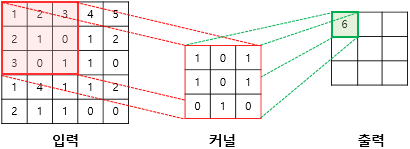

(1×1) + (2×0) + (3×1) + (2×1) + (1×0) + (0×1) + (3×0) + (0×1) + (1×0) = 6

2. 두번째 스텝
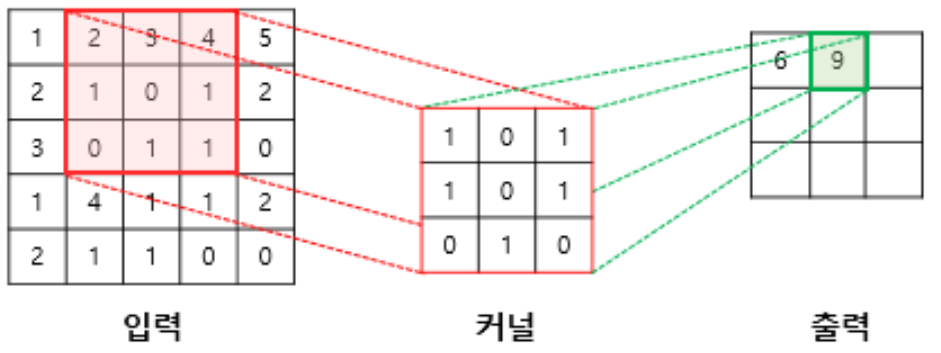

(2×1) + (3×0) + (4×1) + (1×1) + (0×0) + (1×1) + (0×0) + (1×1) + (1×0) = 9

3. 세번째 스텝
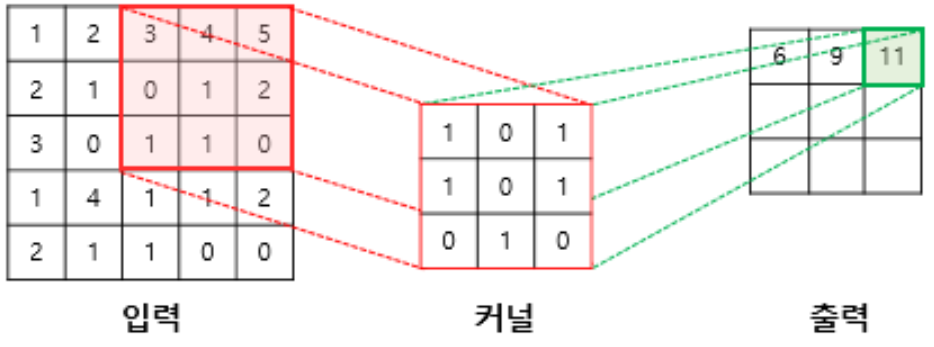
(3×1) + (4×0) + (5×1) + (0×1) + (1×0) + (2×1) + (1×0) + (1×1) + (0×0) = 11

4. 네번째 스텝
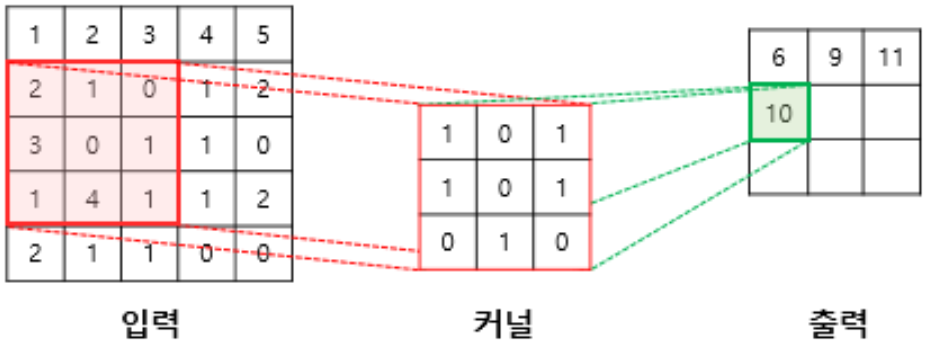
(3×1) + (4×0) + (5×1) + (0×1) + (1×0) + (2×1) + (1×0) + (1×1) + (0×0) = 11

위 연산을 총 9번의 스텝까지 마쳤다고 가정하였을 때, 최종 결과는 아래와 같습니다.
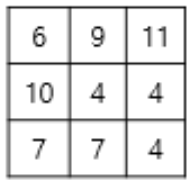


위의 예제에서는 커널의 크기가 3 × 3이었지만, 커널의 크기는 사용자가 정할 수 있습니다. 또한 커널의 이동 범위가 위의 예제에서는 한 칸이었지만, 이 또한 사용자가 정할 수 있습니다. 이러한 이동 범위를 스트라이드(stride)라고 합니다.

아래의 예제는 스트라이드가 2일 경우에 5 × 5 이미지에 합성곱 연산을 수행하는 3 × 3 커널의 움직임을 보여줍니다. 최종적으로 2 × 2의 크기의 특성 맵을 얻습니다.

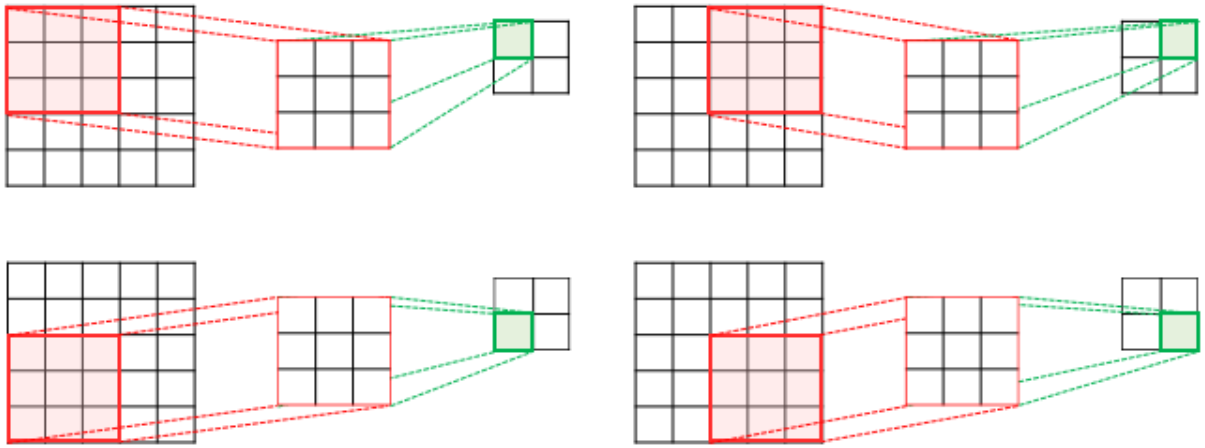

4. 패딩(Padding)
위의 예에서 5 × 5 이미지에 3 × 3의 커널로 합성곱 연산을 하였을 때, 스트라이드가 1일 경우에는 3 × 3의 특성 맵을 얻었습니다. 이와 같이 합성곱 연산의 결과로 얻은 특성 맵은 입력보다 크기가 작아진다는 특징이 있습니다. 만약, 합성곱 층을 여러개 쌓았다면 최종적으로 얻은 특성 맵은 초기 입력보다 매우 작아진 상태가 되버립니다. 합성곱 연산 이후에도 특성 맵의 크기가 입력의 크기와 동일하게 유지되도록 하고 싶다면 패딩(padding)을 사용하면 됩니다.

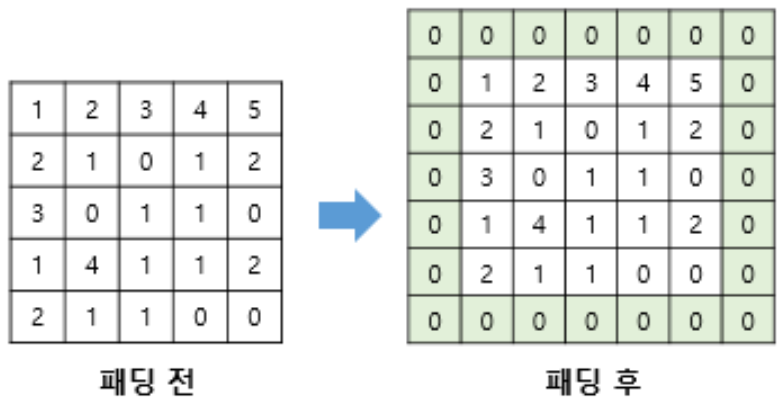

패딩은 (합성곱 연산을 하기 전에) 입력의 가장자리에 지정된 개수의 폭만큼 행과 열을 추가해주는 것을 말합니다. 좀 더 쉽게 설명하면 지정된 개수의 폭만큼 테두리를 추가합니다. 주로 값을 0으로 채우는 제로 패딩(zero padding)을 사용합니다. 위의 그림은 5 × 5 이미지에 1폭짜리 제로 패딩을 사용하여 위, 아래에 하나의 행을 좌, 우에 하나의 열을 추가한 모습을 보여줍니다.

커널은 주로 3 × 3 또는 5 × 5를 사용한다고 언급한 바 있습니다. 만약 스트라이드가 1이라고 하였을 때, 3 × 3 크기의 커널을 사용한다면 1폭짜리 제로 패딩을 사용하고, 5 × 5 크기의 커널을 사용한다면 2폭 짜리 제로 패딩을 사용하면 입력과 특성 맵의 크기를 보존할 수 있습니다. 예를 들어 5 × 5 크기의 이미지에 1폭짜리 제로 패딩을 하면 7 × 7 이미지가 되는데, 여기에 3 × 3의 커널을 사용하여 1 스트라이드로 합성곱을 한 후의 특성 맵은 기존의 입력 이미지의 크기와 같은 5 × 5가 됩니다.

In [16]:
import tensorflow.compat.v1 as tf
from tensorflow.examples.tutorials.mnist import input_data 
tf.disable_v2_behavior()
# 이 예제는 텐서플로 1.14에서 작동합니다.
# 텐서플로 2.X 환경은 keras-mnist.py 예제를 참고하시기 바랍니다.

# MNIST 손글씨 이미지 데이터 읽어 들이기 --- (※1)
mnist = input_data.read_data_sets("mnist/", one_hot=True)
pixels = 28 * 28 # 28x28 픽셀
nums = 10 # 0-9 사이의 카테고리
# 플레이스홀더 정의하기 --- (※2)
x  = tf.placeholder(tf.float32, shape=(None, pixels), name="x") # 이미지 데이터
y_ = tf.placeholder(tf.float32, shape=(None, nums), name="y_")  # 정답 레이블
# 가중치와 바이어스를 초기화하는 함수 --- (※3)
def weight_variable(name, shape):
    W_init = tf.truncated_normal(shape, stddev=0.1)
    W = tf.Variable(W_init, name="W_"+name)
    return W
def bias_variable(name, size):
    b_init = tf.constant(0.1, shape=[size])
    b = tf.Variable(b_init, name="b_"+name)
    return b
# 합성곱 계층을 만드는 함수 --- (※4)
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
# 최대 풀링층을 만드는 함수 --- (※5)
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1],
        strides=[1,2,2,1], padding='SAME')
# 합성곱층1 --- (※6)
with tf.name_scope('conv1') as scope:
    W_conv1 = weight_variable('conv1', [5, 5, 1, 32])
    b_conv1 = bias_variable('conv1', 32)
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
# 풀링층1 ---- (※7)
with tf.name_scope('pool1') as scope:
    h_pool1 = max_pool(h_conv1)
# 합성곱층2 --- (※8)
with tf.name_scope('conv2') as scope:
    W_conv2 = weight_variable('conv2', [5, 5, 32, 64])
    b_conv2 = bias_variable('conv2', 64)
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# 풀링층2 --- (※9)
with tf.name_scope('pool2') as scope:
    h_pool2 = max_pool(h_conv2)
# 전결합층 --- (※10)
with tf.name_scope('fully_connected') as scope:
    n = 7 * 7 * 64
    W_fc = weight_variable('fc', [n, 1024])
    b_fc = bias_variable('fc', 1024)
    h_pool2_flat = tf.reshape(h_pool2, [-1, n])
    h_fc = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc) + b_fc)        
# 드롭아웃(과잉 적합) 막기 --- (※11)
with tf.name_scope('dropout') as scope:
    keep_prob = tf.placeholder(tf.float32)
    h_fc_drop = tf.nn.dropout(h_fc, keep_prob)
# 출력층 --- (※12)
with tf.name_scope('readout') as scope:
    W_fc2 = weight_variable('fc2', [1024, 10])
    b_fc2 = bias_variable('fc2', 10)
    y_conv = tf.nn.softmax(tf.matmul(h_fc_drop, W_fc2) + b_fc2)
# 모델 학습시키기 --- (※13)
with tf.name_scope('loss') as scope:
    cross_entoropy = -tf.reduce_sum(y_ * tf.log(y_conv))
with tf.name_scope('training') as scope:
    optimizer = tf.train.AdamOptimizer(1e-4)
    train_step = optimizer.minimize(cross_entoropy)
# 모델 평가하기 --- (※14)
with tf.name_scope('predict') as scope:
    predict_step = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy_step = tf.reduce_mean(tf.cast(predict_step, tf.float32))
# feed_dict 설정하기 --- (※15)
def set_feed(images, labels, prob):
    return {x: images, y_: labels, keep_prob: prob}
# 세션 시작하기 --- (※16)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # TensorBoard 준비하기
    tw = tf.summary.FileWriter('log_dir', graph=sess.graph)
    # 테스트 전용 피드 만들기
    test_fd = set_feed(mnist.test.images, mnist.test.labels, 1)
    # 학습 시작하기 ---- (※17)
    for step in range(10000):
        batch = mnist.train.next_batch(50)
        fd = set_feed(batch[0], batch[1], 0.5)
        _, loss = sess.run([train_step, cross_entoropy], feed_dict=fd)
        if step % 100 == 0:
            acc = sess.run(accuracy_step, feed_dict=test_fd)
            print("step=", step, "loss=", loss, "acc=", acc)
    # 최종적인 결과 출력하기
    acc = sess.run(accuracy_step, feed_dict=test_fd)
    print("정답률 =", acc)

Instructions for updating:
non-resource variables are not supported in the long term
Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
step= 0 loss= 656.41833 acc= 0.1371
step= 100 loss= 47.71647 acc= 0.8445
step= 200 loss= 21.471935 acc= 0.9036
step= 300 loss= 20.927895 acc= 0.9281
step= 400 loss= 23.147497 acc= 0.9397
step= 500 loss= 19.85801 acc= 0.9477
step= 600 loss= 10.831198 acc= 0.9536
step= 700 loss= 14.848038 acc= 0.9577
step= 800 loss= 8.892637 acc= 0.9596
step= 900 loss= 13.045961 acc= 0.9588
step= 1000 loss= 16.49296 acc= 0.9617
step= 1100 loss= 13.013065 acc= 0.9627
step= 1200 loss= 8.026761 acc= 0.9669
step= 1300 loss= 3.2778964 acc= 0.9657
step= 1400 loss= 7.940196 acc= 0.9694
step= 1500 loss= 7.23276 acc= 0.9682
step= 1600 loss= 5.353

In [17]:
#  Keras로 다양한 딥러닝 해보기


from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
# MNIST 데이터 읽어 들이기 --- (※1)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 데이터를 float32 자료형으로 변환하고 정규화하기 --- (※2)
X_train = X_train.reshape(60000, 784).astype('float32')
X_test  = X_test.reshape(10000, 784).astype('float')
X_train /= 255
X_test  /= 255
# 레이블 데이터를 0-9까지의 카테고리를 나타내는 배열로 변환하기 --- (※2a)
y_train = utils.to_categorical(y_train, 10)
y_test  = utils.to_categorical(y_test, 10)
# 모델 구조 정의하기 --- (※3)
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))
# 모델 구축하기 --- (※4)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'])
# 데이터 훈련하기 --- (※5)
hist = model.fit(X_train, y_train)
# 테스트 데이터로 평가하기 --- (※6)
score = model.evaluate(X_test, y_test, verbose=1)
print('loss=', score[0])
print('accuracy=', score[1])

11501568/11490434 [==============================] - 1s 0us/step
Train on 60000 samples
60000/60000 [==============================] - 9s 143us/sample - loss: 0.2193 - acc: 0.9326


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


loss= 0.10841566259423271
accuracy= 0.9654


In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd, numpy as np
# BMI 데이터를 읽어 들이고 정규화하기 --- (※1)
csv = pd.read_csv("bmi.csv")
# 몸무게와 키 데이터
csv["weight"] /= 100
csv["height"] /= 200
X = csv[["weight", "height"]]  # --- (※1a)
# 레이블
bclass = {"thin":[1,0,0], "normal":[0,1,0], "fat":[0,0,1]}
y = np.empty((20000,3))
for i, v in enumerate(csv["label"]):
    y[i] = bclass[v]
# 훈련 전용 데이터와 테스트 전용 데이터로 나누기 --- (※2)
X_train, y_train = X[1:15001], y[1:15001]
X_test,  y_test  = X[15001:20001], y[15001:20001] 
# 모델 구조 정의하기 --- (※3)
model = Sequential()
model.add(Dense(512, input_shape=(2,)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(3))
model.add(Activation('softmax'))
# 모델 구축하기 --- (※4)
model.compile(
    loss='categorical_crossentropy',
    optimizer="rmsprop",
    metrics=['accuracy'])
# 데이터 훈련하기 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=20,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=1)
# 테스트 데이터로 평가하기 --- (※6)
score = model.evaluate(X_test, y_test)
print('loss=', score[0])
print('accuracy=', score[1])

Train on 13500 samples, validate on 1500 samples
Epoch 1/20
13500/13500 [==============================] - 1s 63us/sample - loss: 0.5086 - acc: 0.7850 - val_loss: 0.3523 - val_acc: 0.8400
Epoch 2/20
13500/13500 [==============================] - 1s 53us/sample - loss: 0.2447 - acc: 0.9045 - val_loss: 0.1400 - val_acc: 0.9807
Epoch 3/20
13500/13500 [==============================] - 1s 42us/sample - loss: 0.1927 - acc: 0.9217 - val_loss: 0.1096 - val_acc: 0.9727
Epoch 4/20
13500/13500 [==============================] - 1s 45us/sample - loss: 0.1681 - acc: 0.9261 - val_loss: 0.0943 - val_acc: 0.9793
Epoch 5/20
13500/13500 [==============================] - 1s 49us/sample - loss: 0.1510 - acc: 0.9353 - val_loss: 0.0887 - val_acc: 0.9693
Epoch 6/20
13500/13500 [==============================] - 1s 45us/sample - loss: 0.1454 - acc: 0.9407 - val_loss: 0.0857 - val_acc: 0.9667
Epoch 7/20
13500/13500 [==============================] - 1s 47us/sample - loss: 0.1318 - acc: 0.9447 - val_loss: 0.0

[3, 4, 5]
